<a href="https://colab.research.google.com/github/alanagadelha/MachineLearning/blob/main/Previsao_Antartica_SCRM_Alana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This tutorial is an introduction to time series forecasting using TensorFlow. It builds a few different styles of models including Convolutional and Recurrent Neural Networks (CNNs and RNNs).

This is covered in two main parts, with subsections:

* Forecast for a single time step:
  * A single feature.
  * All features.
* Forecast multiple steps:
  * Single-shot: Make the predictions all at once.
  * Autoregressive: Make one prediction at a time and feed the output back to the model.

In [387]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## METAR (dado de estação) da Base Presidente Eduardo Frei Montalva (SCRM), Chile

In [426]:
from google.colab import drive
drive.mount('/content/drive')
my_path = '/content/drive/MyDrive/Colab Notebooks/metar_frei_2010-a-2025-processado.csv'
df = pd.read_csv(my_path)
df.tail(100)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,time,temp,dwpt,rhum,prcp,wdir,pres,coco,wspd_knots
106013,2025-05-26 21:00:00,-3.2,-6.4,84.0,0.0,241.0,1021.1,3.0,35.75
106014,2025-05-26 22:00:00,-2.7,-6.1,83.0,0.0,218.0,1021.5,3.0,22.73
106015,2025-05-26 23:00:00,-2.5,-6.3,81.0,0.0,230.0,1021.4,3.0,8.96
106016,2025-05-27 00:00:00,-2.5,-5.9,83.0,0.0,230.0,1021.8,3.0,6.05
106017,2025-05-27 01:00:00,-2.5,-5.7,84.0,0.1,226.0,1022.0,14.0,6.05
...,...,...,...,...,...,...,...,...,...
106108,2025-05-30 20:00:00,-0.9,-1.3,98.0,0.0,352.0,1012.1,5.0,35.21
106109,2025-05-30 21:00:00,-1.2,-1.6,98.0,0.0,338.0,1012.2,5.0,38.50
106110,2025-05-30 22:00:00,-1.0,-1.4,98.0,0.0,2.0,1012.1,5.0,35.75
106111,2025-05-30 23:00:00,-0.7,-1.1,98.0,0.0,343.0,1012.6,5.0,48.38


In [417]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,106113.0,-1.911455,3.696699,-21.9,-3.00,-1.0,0.50,9.00
dwpt,106113.0,-3.915516,4.716537,-27.1,-6.30,-2.6,-0.40,6.00
rhum,106113.0,89.994373,9.277368,0.0,85.00,93.0,99.00,100.00
prcp,106113.0,0.053124,0.208310,0.0,0.00,0.0,0.00,6.00
wdir,106113.0,212.902029,110.151194,0.0,110.00,250.0,300.00,360.00
pres,106113.0,989.796784,12.452223,935.8,981.50,989.5,998.10,1031.10
coco,106113.0,1.863843,3.808194,0.0,0.00,0.0,3.00,22.00
wspd_knots,106113.0,18.414903,11.316149,0.0,11.07,16.9,22.95,134.72


In [ ]:
!pip install ydata-profiling -q
from ydata_profiling import ProfileReport
ProfileReport(df)

In [427]:
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)


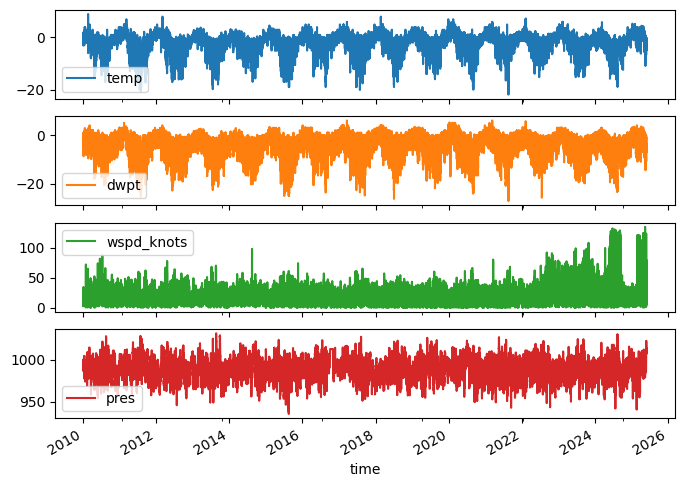

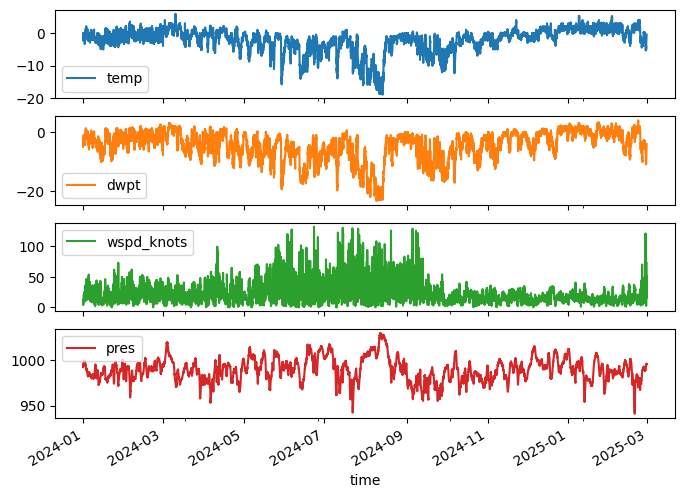

In [428]:
plot_cols = ['temp', 'dwpt', 'wspd_knots', 'pres']
plot_features = df[plot_cols]
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols]['2024-01-01':'2025-02-28']
_ = plot_features.plot(subplots=True)

In [429]:
# Retirando os últimos anos desta análise, devido ao comportamente estranho do vento!
# Provavelmente erros na série tepomral
df = df[(df.index.year >= 2010) & (df.index.year <= 2022)]


Text(0, 0.5, 'Velocidade do vento (nós)')

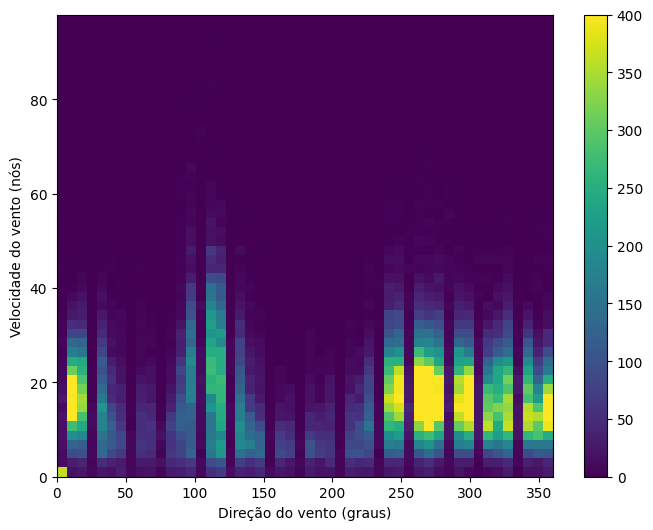

In [430]:
#Atualmente, a distribuição dos dados de vento se parece com esta:
plt.hist2d(df['wdir'], df['wspd_knots'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Direção do vento (graus)')
plt.ylabel('Velocidade do vento (nós)')

## Vento

A coluna da direção do vento está graus (º). Mas ângulos não são bons parâmetros de entrada do modelo: 360° e 0° devem estar próximos um do outro.

Será mais fácil para o modelo interpretar se você converter as colunas de direção e velocidade do vento em um vetor de vento.

*np.pi / 180: Converte a direção do vento de graus para radianos. A maioria das funções trigonométricas (seno, cosseno) em bibliotecas como NumPy espera ângulos em radianos, não em graus. Esta é a conversão padrão ($180^\\circ = \\pi$ radianos).

(np.float64(-88.78645771860754),
 np.float64(79.47412984524384),
 np.float64(-96.46191940754578),
 np.float64(56.26879413266019))

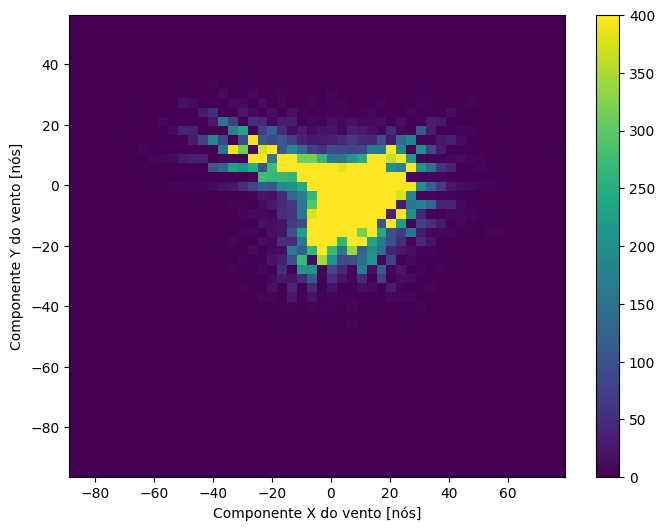

In [431]:
# Converter direção de onde o vento vem para para onde ele vai
wdir_cartesiano = (270 - df['wdir']) % 360
wdir_rad = np.radians(wdir_cartesiano)

df.loc[:,'wind_compX'] = df['wspd_knots'] * np.cos(wdir_rad)
df.loc[:,'wind_compY'] = df['wspd_knots'] * np.sin(wdir_rad)

plt.hist2d(df['wind_compX'], df['wind_compY'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Componente X do vento [nós]')
plt.ylabel('Componente Y do vento [nós]')
ax = plt.gca()
ax.axis('tight')

In [432]:
wspd_knots = df.pop('wspd_knots')
coco = df.pop('coco')
prcp = df.pop('prcp')

In [433]:
df.loc[:,'year'] = df.index.year
df.loc[:,'month'] = df.index.month
df.loc[:,'day'] = df.index.day
df.loc[:,'hour'] = df.index.hour

E semelhante à direção do vento, o tempo em segundos não é uma entrada útil do modelo. Sendo dados meteorológicos,** eles têm uma periodicidade diária e anual clara**.
porquê de usar transformações senoidais e cossenoidais (sinais) para o tempo, em vez de datetime ou timestamp brutos, especialmente em modelos de aprendizado de máquina que lidam com dados de séries temporais.

Periodicidade:

1.   Problema com datetime e timestamp:

* O tempo é naturalmente cíclico. Um datetime como '2023-01-01 08:00:00' e '2024-01-01 08:00:00' representam a mesma "hora do dia" (8 AM), mas estão distantes em termos de timestamp. Se um modelo de aprendizado de máquina visse apenas o timestamp, ele interpretaria o tempo como uma variável linear, onde 8 AM de um dia é muito diferente de 8 AM de outro dia, e 23:00 é "longe" de 01:00, mesmo que sejam apenas algumas horas de diferença no ciclo diário.

* Solução com Sinais (Senos e Cossenos): Ao usar as transformações de seno e cosseno, você está explicitamente informando ao modelo sobre a natureza cíclica do tempo.
  * sin(2 * pi * t / Periodo) e cos(2 * pi * t / Periodo) mapeiam o tempo linear (t) para um círculo.
  * Para a "hora do dia" (período de 24 horas), 23:00 e 01:00 estarão próximas no círculo, assim como 08:00 de um dia e 08:00 do dia seguinte.
  * Isso permite que o modelo aprenda padrões que se repetem diariamente (como temperaturas mais altas à tarde ou tráfego intenso em horários de pico) ou anualmente (como estações do ano, tendências de consumo de energia, etc.).

3. Representação Contínua e Suave:

* datetime é uma representação categórica/discreta se você extrair apenas a hora do dia ou o mês.
* timestamp é uma variável numérica contínua, mas linear.
* As funções seno e cosseno fornecem uma representação contínua e suave da posição no ciclo. Não há "saltos" abruptos entre o final de um período e o início do próximo. Por exemplo, a transição de 23:59 para 00:00 é suave quando mapeada para um círculo.

4. Captura de Relações Não Lineares:

* Muitos modelos de aprendizado de máquina (especialmente modelos lineares ou baseados em árvores, a menos que sejam configurados com interações) têm dificuldade em capturar relações não lineares complexas.

* Ao transformar o tempo em componentes seno e cosseno, você está criando novas características que já codificam essa relação cíclica de forma que o modelo pode aprender mais facilmente. Se você usasse apenas a "hora do dia" como um número inteiro (0-23), o modelo poderia inferir que 23 é muito diferente de 0, e 11 é "metade" de 22, o que não é verdade para um ciclo. A diferença entre 23h e 0h é apenas 1 hora, mas a distância numérica é 23. Os sinais resolvem isso.

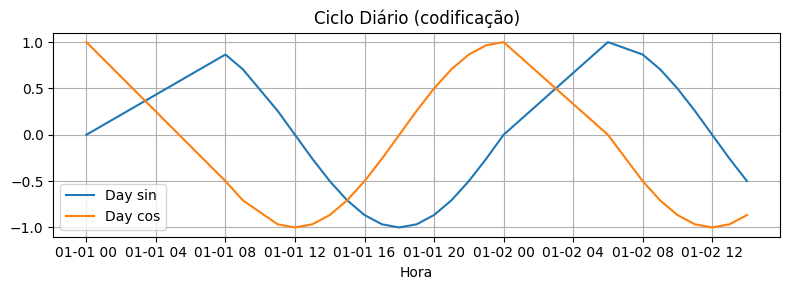

In [434]:
# Garantir que o índice está em datetime
df.index = pd.to_datetime(df.index)

# Transformar o índice para timestamp em segundos
timestamp_s = df.index.view('int64') // 1_000_000_000  # segundos desde época UNIX

# Constantes
day = 24*60*60
year = 365.2425*day

# Cálculo dos componentes sazonais
df.loc[:,'Day sin'] = np.sin(2 * np.pi * timestamp_s / day)
df.loc[:,'Day cos'] = np.cos(2 * np.pi * timestamp_s / day)
df.loc[:,'Year sin'] = np.sin(2 * np.pi * timestamp_s / year)
df.loc[:,'Year cos'] = np.cos(2 * np.pi * timestamp_s / year)

# Visualizar o ciclo diário nos primeiros 24 pontos (ou 25 horas)
plt.figure(figsize=(8, 3))
plt.plot(df['Day sin'][:25], label='Day sin')
plt.plot(df['Day cos'][:25], label='Day cos')
plt.xlabel('Hora')
plt.title('Ciclo Diário (codificação)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [435]:
df.head()
df.describe().transpose()
df.isna().any().any()

np.False_

## Dividir os dados (Split the data)

Você usará uma divisão **(70%, 20%, 10%)** para os conjuntos de **treinamento, validação e teste**. Observe que os dados não são embaralhados aleatoriamente antes da divisão. Isso ocorre por dois motivos:

Isso garante que ainda seja possível dividir os dados em janelas de amostras consecutivas.
Isso garante que os resultados da validação/teste sejam mais realistas, sendo avaliados com base nos dados coletados após o treinamento do modelo.

In [436]:
column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)
print(n)

train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

85009


## Normalização (escalonamento) dos dados
É importante escalonar os atributos antes de treinar uma rede neural. A normalização é a maneira mais comum de fazer esse escalonamento. Fórmula => [atributo(feature-média]/[desvio padrão], isso para cada atributo do conjunto de dados.

### Importante:
A média e o desvio padrão devem ser calculados apenas usando os dados de treinamento para que **os modelos não tenham acesso aos valores nos conjuntos de validação e teste.**

In [437]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

/tmp/ipython-input-439-2643887104.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


,Column,Normalized
0,temp,-0.070168
1,temp,-0.252432
2,temp,-0.252432
3,temp,0.007945
4,temp,0.216246


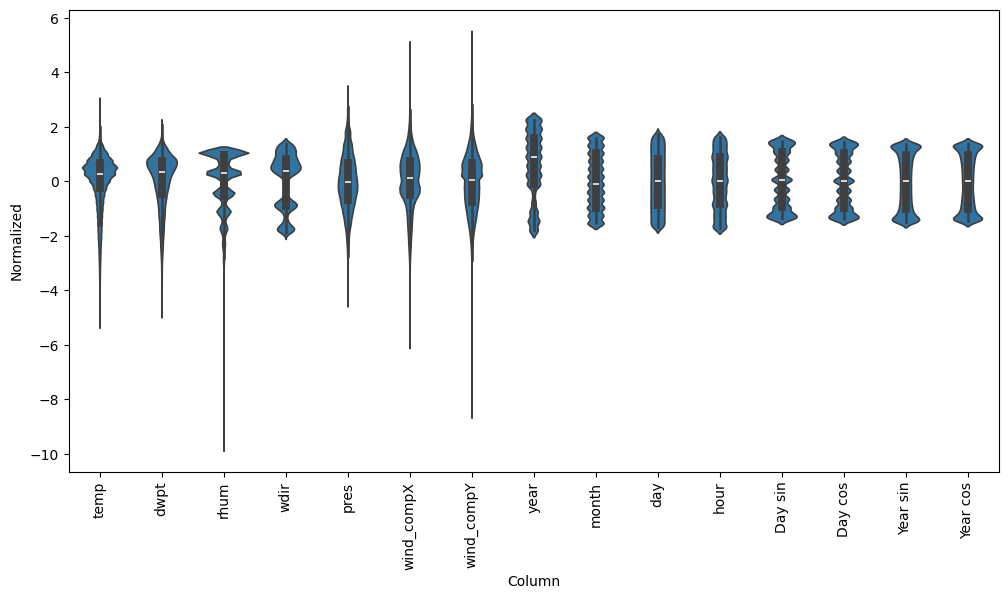

In [439]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

df_std.head()

In [440]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):

    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [441]:
#Primeira janela com shift de 24 horas, com 72 horas de dados anteriores
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['temp'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['temp']

In [442]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['temp'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['temp']

In [443]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [444]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 15)
Inputs shape: (3, 6, 15)
Labels shape: (3, 1, 1)


In [445]:
w2.example = example_inputs, example_labels

In [446]:
def plot(self, model=None, plot_col='temp', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normalizado]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()
  #plt.title('Temperaturas')
  plt.xlabel('Tempo [horas]')

WindowGenerator.plot = plot

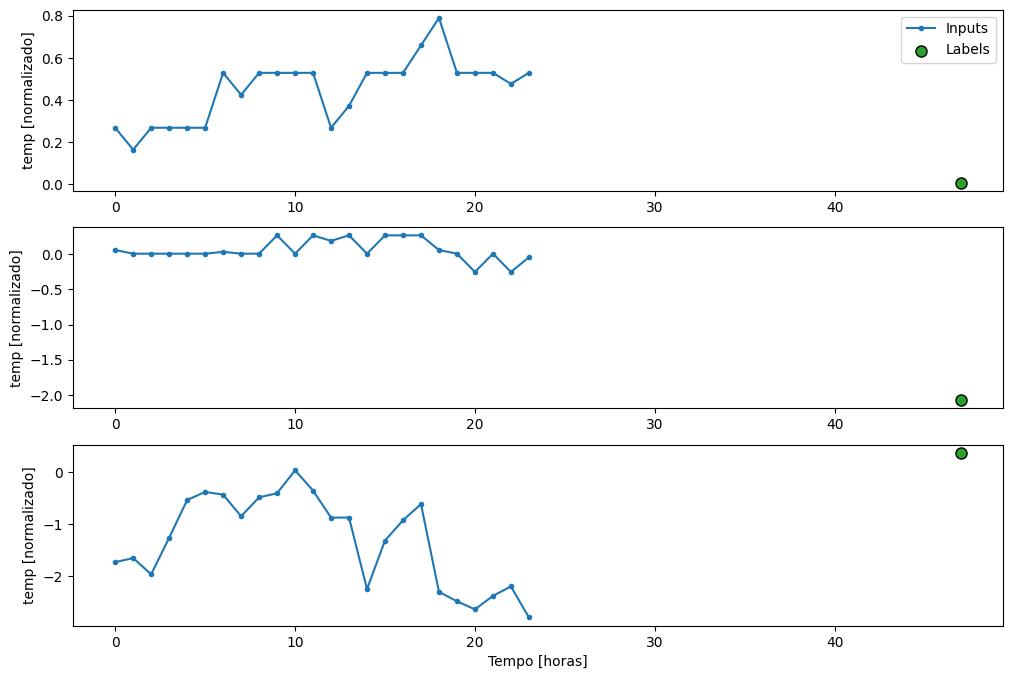

In [513]:
w1.plot()

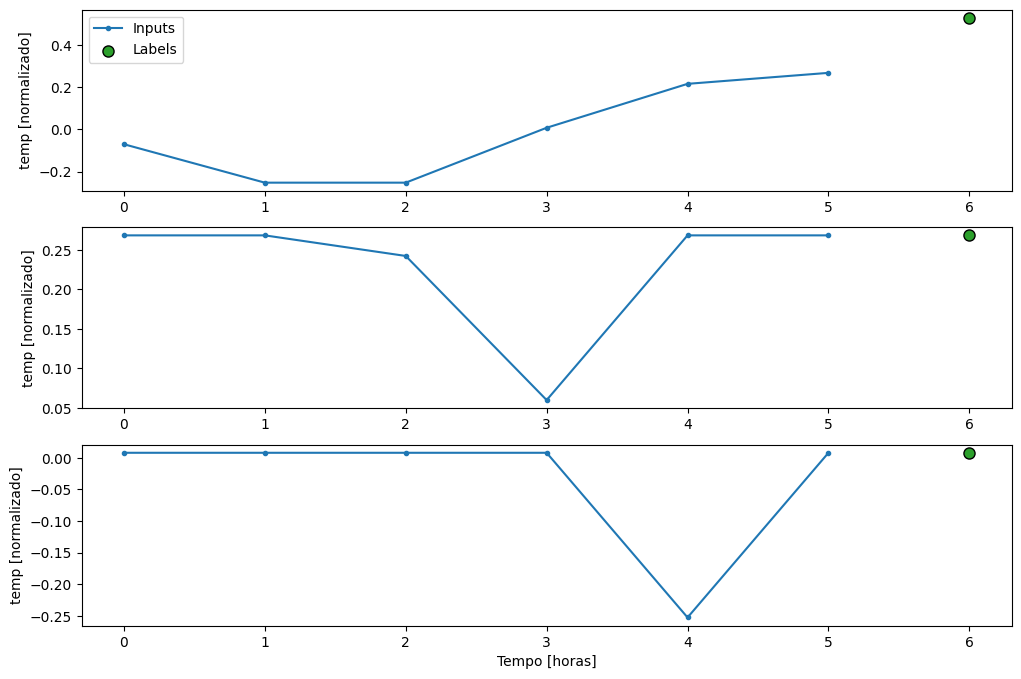

In [447]:
w2.plot()

Create tf.data.Datasets

Finally, this make_dataset method will take a time series DataFrame and convert it to a tf.data.Dataset of (input_window, label_window) pairs using the tf.keras.utils.timeseries_dataset_from_array function:

In [451]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [452]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [453]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 15), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [454]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 15)
Labels shape (batch, time, features): (32, 1, 1)


Single step models
The simplest model you can build on this sort of data is one that predicts a single feature's value—1 time step (one hour) into the future based only on the current conditions.

So, start by building models to predict the T (degC) value one hour into the future.
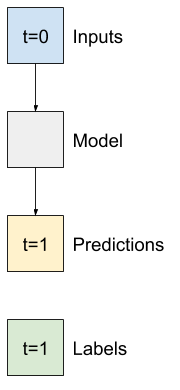

Predict the next time step

Configure a WindowGenerator object to produce these single-step (input, label) pairs:

In [455]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['temp'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['temp']

In [456]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 15)
Labels shape (batch, time, features): (32, 1, 1)


In [457]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [458]:
baseline = Baseline(label_index=column_indices['temp'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0242 - mean_absolute_error: 0.0973


loss: 0.3....Valor da função de perda, que é o Mean Squared Error (MSE) neste caso. Indica o erro quadrático médio entre as predições e os valores reais. Quanto menor, melhor. O MSE de 0.02....mostra a média dos erros quadrados, que penaliza erros maiores.

mean_absolute_error: 0.3 Métrica de erro médio absoluto (MAE). Representa a média das diferenças absolutas entre as predições e valores reais. O baseline está errando em média cerca de 0.3 unidades da variável prevista (exemplo: graus de temperatura, se for temperatura).


In [459]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['temp'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['temp']

In [460]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 15)
Output shape: (32, 24, 1)


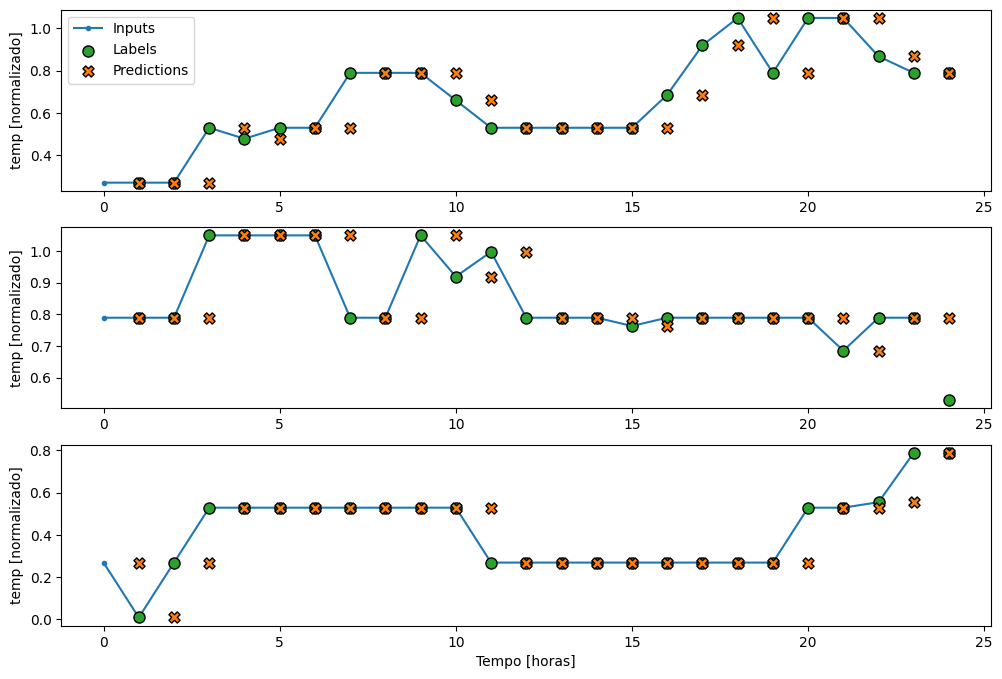

In [461]:
wide_window.plot(baseline)

In [360]:
#wide_window = WindowGenerator(input_width=72, label_width=72, shift=1, label_columns=['temp'])

#wide_window

#wide_window.plot(baseline)

#val_performance = {}
#performance = {}

# Avalia baseline
#val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
#performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

#print("Val Performance:")
#print(val_performance)

#print("\nTest Performance:")
#print(performance)

## Linear model

The simplest trainable model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:
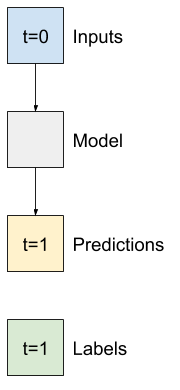



In [462]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 15)
Output shape: (32, 1, 1)


In [463]:
MAX_EPOCHS = 20

# O método "early_stopping" monitora o desempenho do modelo durante o treino.
# Ela monitora a métrica 'val_loss' (perda no conjunto de validação).
# Se a validação não melhorar após patience épocas (aqui, 2), o treino para antes do limite máximo.
# mode='min' indica que queremos minimizar a perda.
# patience: quantas épocas o treino espera para tentar melhorar a validação antes de parar (early stopping).

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [464]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val, return_dict=True)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.2681 - mean_absolute_error: 0.3618 - val_loss: 0.0244 - val_mean_absolute_error: 0.1052
Epoch 2/20
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.0347 - mean_absolute_error: 0.1148 - val_loss: 0.0244 - val_mean_absolute_error: 0.1050
Epoch 3/20
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.0347 - mean_absolute_error: 0.1149 - val_loss: 0.0246 - val_mean_absolute_error: 0.1054
Epoch 4/20
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.0346 - mean_absolute_error: 0.1148 - val_loss: 0.0245 - val_mean_absolute_error: 0.1057
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0244 - mean_absolute_error: 0.1058


In [465]:
# Descobrindo de onde vem os NaN......

import numpy as np

for x, y in single_step_window.train.take(1):
    print("X contém NaN?", np.isnan(x.numpy()).any())
    print("X contém inf?", np.isinf(x.numpy()).any())
    print("Y contém NaN?", np.isnan(y.numpy()).any())
    print("Y contém inf?", np.isinf(y.numpy()).any())

for x, y in single_step_window.train.take(1):
    print("X contém NaN?", np.isnan(x.numpy()).any())
    print("Y contém NaN?", np.isnan(y.numpy()).any())

x_np = x.numpy()  # (32, 24, 18)
nan_mask = np.isnan(x_np)  # mesma forma, True onde NaN

# Quantos NaNs por feature (somando sobre batch e time_steps)
nan_count_per_feature = nan_mask.sum(axis=(0,1))

print("NaNs por feature (0 a 17):", nan_count_per_feature)

for idx, count in enumerate(nan_count_per_feature):
    if count > 0:
        print(f"Feature {idx} ({list(column_indices.keys())[list(column_indices.values()).index(idx)]}) tem {count} NaNs")

X contém NaN? False
X contém inf? False
Y contém NaN? False
Y contém inf? False
X contém NaN? False
Y contém NaN? False
NaNs por feature (0 a 17): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Input shape: (32, 24, 15)
Output shape: (32, 24, 1)


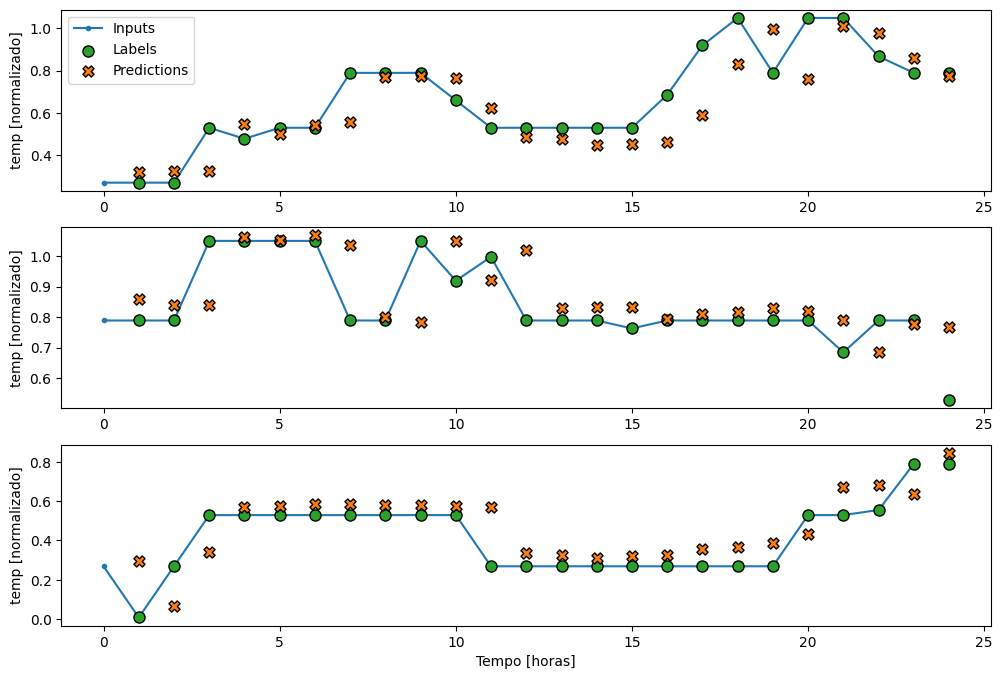

In [466]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

wide_window.plot(linear)

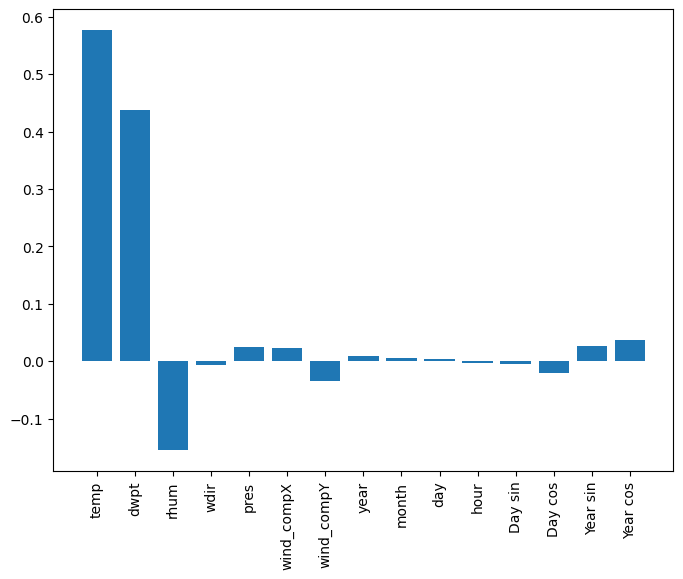

In [467]:
plt.bar(x = range(len(train_df.columns)), height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()

axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

## MODELO SEQUENCIAL KERAS CHAMADO DENSE **perceptron multicamadas (MLP)**

Before applying models that actually operate on multiple time-steps, it's worth checking the performance of deeper, more powerful, single input step models.

Here's a model similar to the linear model, except it stacks several a few Dense layers between the input and the output.

**perceptron multicamadas (MLP)** simples para problemas de regressão, como o nosso para prever estimar temperatura.

Esse modelo tem 3 camadas densas (fully connected):
* Primeira camada: 64 neurônios, função de ativação ReLU (relu), que introduz não linearidade.

* Segunda camada: mais 64 neurônios com ativação ReLU.

* Terceira camada: camada de saída com 1 neurônio (sem ativação explícita, padrão é linear), para regressão (ex: prever temperatura).



In [471]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0906 - mean_absolute_error: 0.1876 - val_loss: 0.0277 - val_mean_absolute_error: 0.1161
Epoch 2/20
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0361 - mean_absolute_error: 0.1240 - val_loss: 0.0263 - val_mean_absolute_error: 0.1121
Epoch 3/20
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0350 - mean_absolute_error: 0.1205 - val_loss: 0.0252 - val_mean_absolute_error: 0.1078
Epoch 4/20
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.0345 - mean_absolute_error: 0.1187 - val_loss: 0.0244 - val_mean_absolute_error: 0.1056
Epoch 5/20
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.0344 - mean_absolute_error: 0.1184 - val_loss: 0.0247 - val_mean_absolute_error: 0.1069
Epoch 6/20
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.0341 - mean_absolute_error: 0.1180 - val_loss: 0.0253 - val_mean_absolute_error: 0.1092
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0253 - mean_absolute_error: 0.1

O erro deu alto e o gráfico abaixo mostra isso:

* Vamos aplicar o Dropout ou aqui vou aplicar => L2 regularization para evitar overfitting.

Input shape: (32, 24, 15)
Output shape: (32, 24, 1)


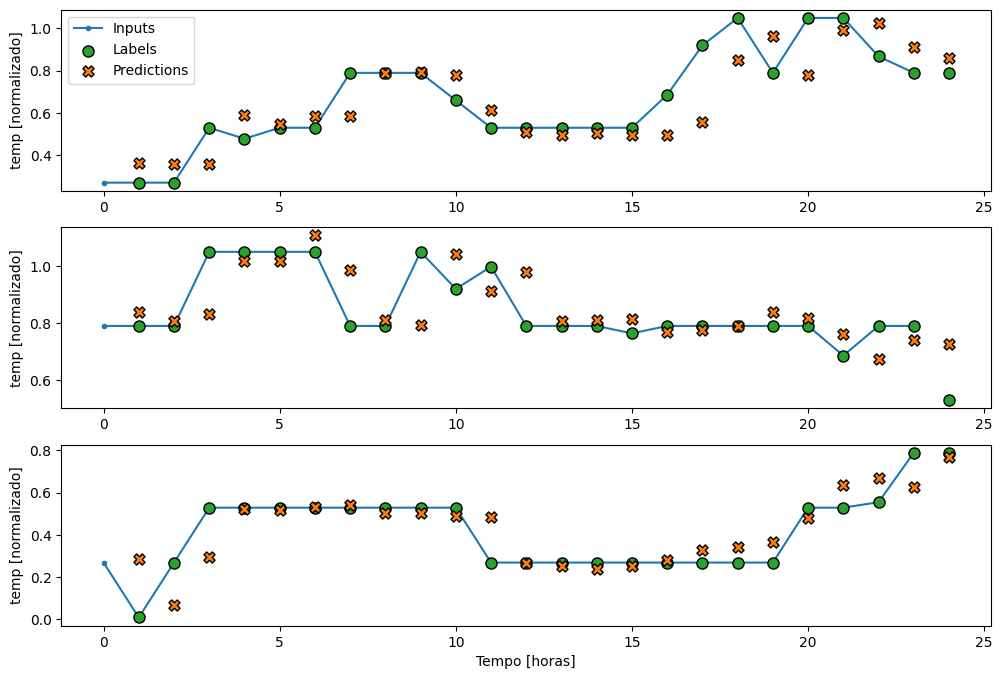

In [469]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

wide_window.plot(dense)

In [470]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.1989 - mean_absolute_error: 0.2414 - val_loss: 0.0505 - val_mean_absolute_error: 0.1132
Epoch 2/20
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0613 - mean_absolute_error: 0.1398 - val_loss: 0.0411 - val_mean_absolute_error: 0.1236
Epoch 3/20
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0479 - mean_absolute_error: 0.1321 - val_loss: 0.0375 - val_mean_absolute_error: 0.1248
Epoch 4/20
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.0437 - mean_absolute_error: 0.1283 - val_loss: 0.0525 - val_mean_absolute_error: 0.1698
Epoch 5/20
1860/1860 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0421 - mean_absolute_error: 0.1261 - val_loss: 0.0536 - val_mean_absolute_error: 0.1684
532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0549 - mean_absolute_error: 0.1694


In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

wide_window.plot(dense)

**Multi-step dense**

A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions. The baseline, linear and dense models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a WindowGenerator that will produce batches of three-hour inputs and one-hour labels:

Note that the Window's shift parameter is relative to the end of the two windows.

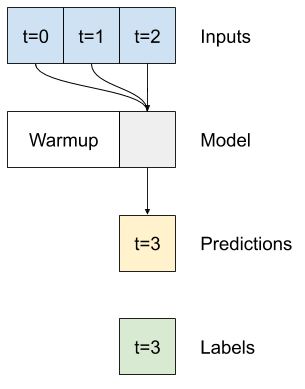

Text(0.5, 0.98, 'Dada 3 horas de INPUT, o modelo estima 1 hora a frente.')

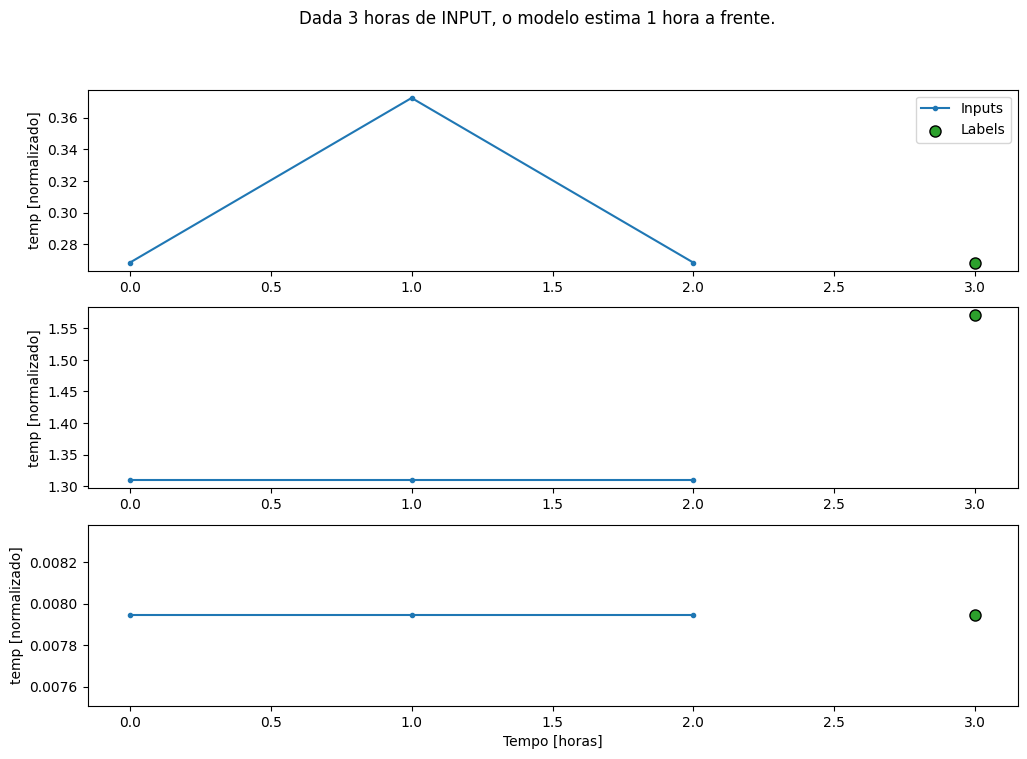

In [472]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['temp'])

conv_window
conv_window.plot()

plt.suptitle("Dada 3 horas de INPUT, o modelo estima 1 hora a frente.")

Vamos treinar uma modelo de Multiple-Input-STEP adicionando tf.keras.layers.Flatten na primeira camada do modelo.

In [473]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [474]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 15)
Output shape: (32, 1, 1)


In [475]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val, return_dict=True)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0, return_dict=True)

532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0246 - mean_absolute_error: 0.1070


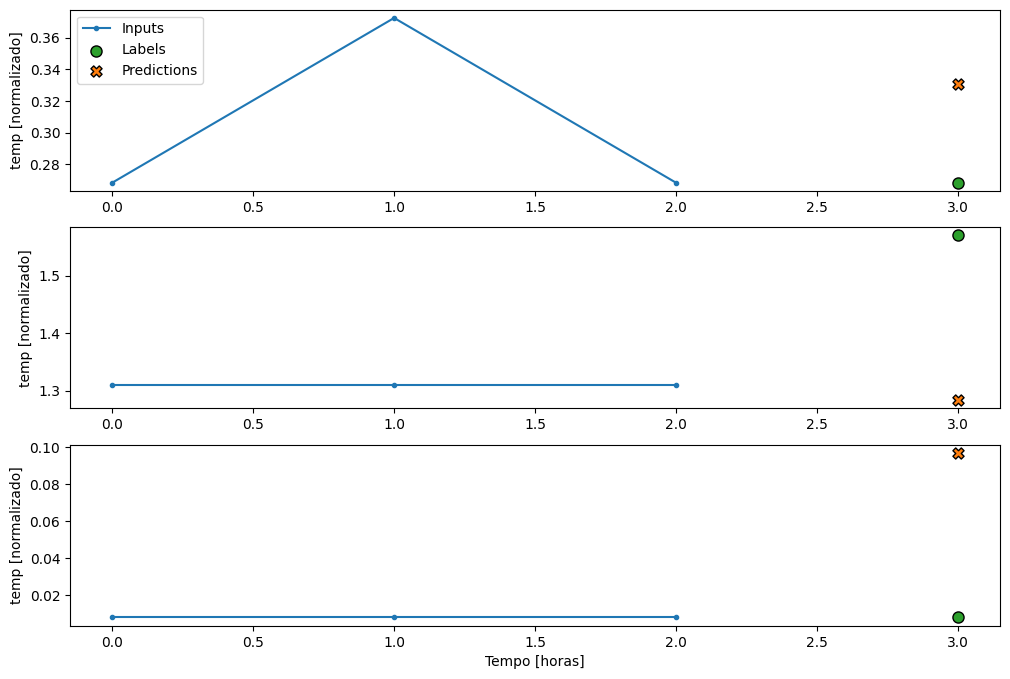

In [476]:
conv_window.plot(multi_step_dense)

In [477]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

# O problema:
# input com shape (32, 24, 18) (batch de 32 janelas, cada uma com 24 passos de tempo e 18 variáveis) para um modelo Sequential que espera entrada com última dimensão = 54.
# expected axis -1 of input shape to have value 54, but received input with shape (32, 432)
# indica que, em algum lugar, o modelo foi configurado para esperar vetores de entrada de tamanho 54,
# mas está recebendo algo com shape=(32, 24, 18).

# causa:
# Você deve ter "achatado" a entrada para (batch_size, 432) dentro do modelo — usando Flatten() ou Reshape(), porque:
# 24 (time steps) × 18 (features) = 432 e isso conflita com o que o Sequential espera.

Input shape: (32, 24, 15)

ValueError:Exception encountered when calling Sequential.call().

Input 0 of layer "dense_78" is incompatible with the layer: expected axis -1 of input shape to have value 45, but received input with shape (32, 360)

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 24, 15), dtype=float32)
  • training=None
  • mask=None


Vamos resolver o problema acima com:
## Convolution neural network

A convolution layer (tf.keras.layers.Conv1D) also takes multiple time steps as input to each prediction. Below is the same model as multi_step_dense, re-written with a convolution.

Note the changes:
The tf.keras.layers.Flatten and the first tf.keras.layers.Dense are replaced by a tf.keras.layers.Conv1D.

The tf.keras.layers.Reshape is no longer necessary since the convolution keeps the time axis in its output.

In [478]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [479]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 15)
Output shape: (32, 1, 1)


Train and evaluate it on the conv_window and it should give performance similar to the multi_step_dense model.

In [480]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val, return_dict=True)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0, return_dict=True)

532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0257 - mean_absolute_error: 0.1082


In [481]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 15)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Observe que a saída é menor que a entrada. Para que o treinamento ou a plotagem funcionem, é necessário que os rótulos e a previsão tenham o mesmo comprimento. Portanto, crie um WindowGenerator para produzir janelas amplas com alguns passos de tempo de entrada extras para que os comprimentos dos rótulos e da previsão correspondam:

In [482]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['temp'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['temp']

In [483]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 15)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


532/532 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0244 - mean_absolute_error: 0.1066


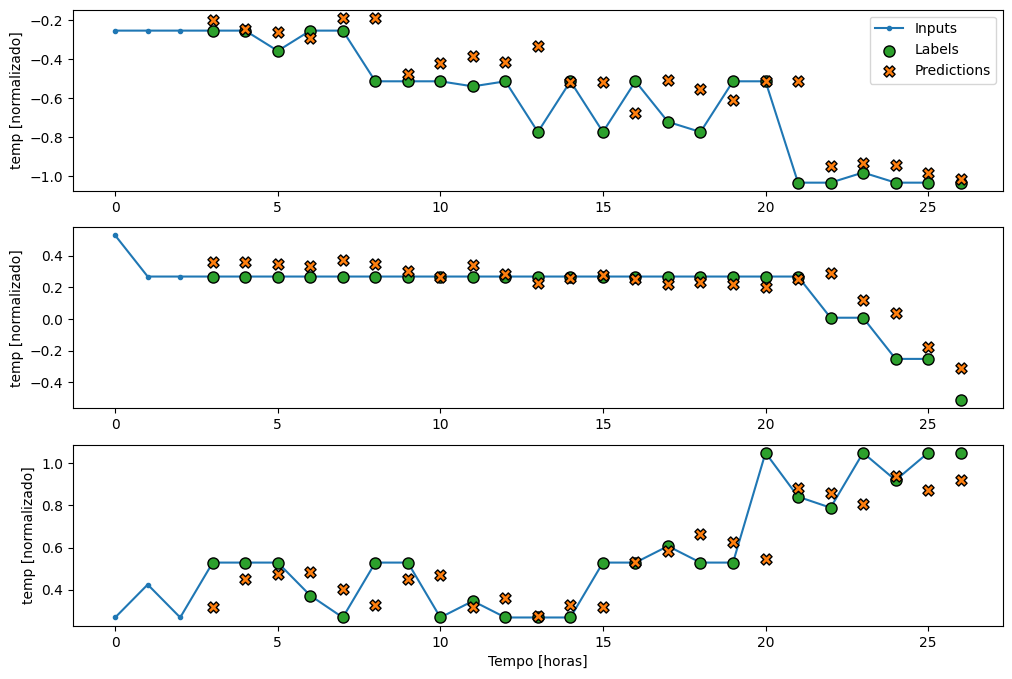

In [484]:
wide_conv_window.plot(conv_model)

IPython.display.clear_output()

val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val, return_dict=True)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0, return_dict=True)

## Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

You can learn more in the Text generation with an RNN tutorial and the Recurrent Neural Networks (RNN) with Keras guide.

In this tutorial, you will use an RNN layer called Long Short-Term Memory (tf.keras.layers.LSTM).

An important constructor argument for all Keras RNN layers, such as tf.keras.layers.LSTM, is the return_sequences argument. This setting can configure the layer in one of two ways:

* **If False**, the default, the layer only returns the output of the final time step, giving the model time to warm up its internal state before making a single prediction:

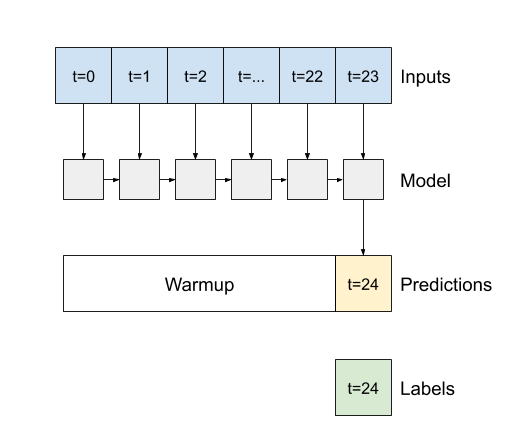

*** the layer returns** an output for each input. This is useful for:
Stacking RNN layers.
Training a model on multiple time steps simultaneously.

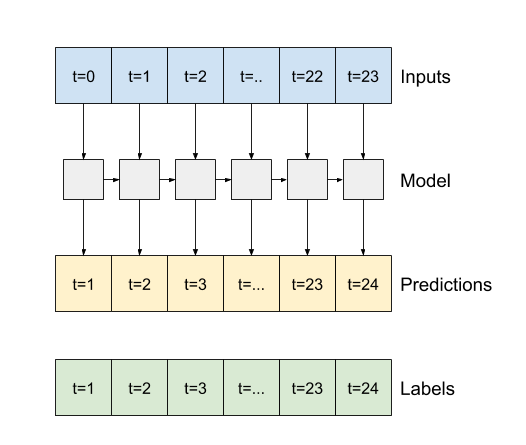

In [488]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

531/531 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0233 - mean_absolute_error: 0.1034


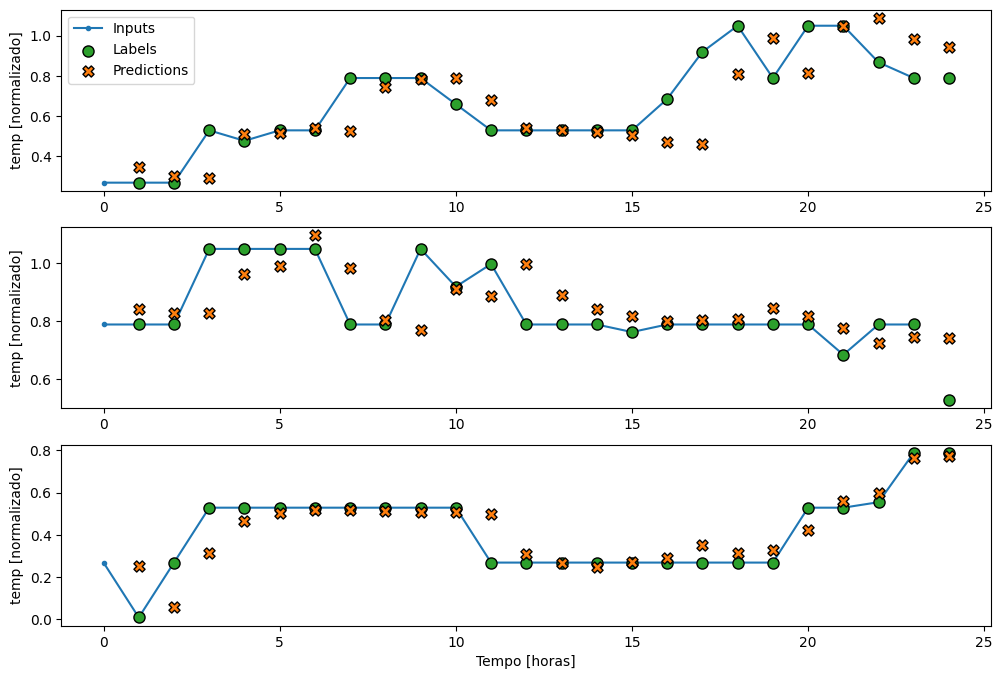

In [489]:
wide_window.plot(lstm_model)

In [490]:
cm = lstm_model.metrics[1]
cm.metrics

val_performance

{'Baseline': {'loss': 0.025220204144716263,
  'mean_absolute_error': 0.09856806695461273},
 'Linear': {'loss': 0.024527791887521744,
  'mean_absolute_error': 0.10570570826530457},
 'Dense': {'loss': 0.025320054963231087,
  'mean_absolute_error': 0.10919906944036484},
 'Multi step dense': {'loss': 0.024562399834394455,
  'mean_absolute_error': 0.10701664537191391},
 'Conv': {'loss': 0.025429699569940567,
  'mean_absolute_error': 0.10836861282587051},
 'LSTM': {'loss': 0.023645343258976936,
  'mean_absolute_error': 0.10404109209775925}}

Baseline    : 0.1157
Linear      : 0.1206
Dense       : 0.1169
Multi step dense: 0.1194
Conv        : 0.1197
LSTM        : 0.1196


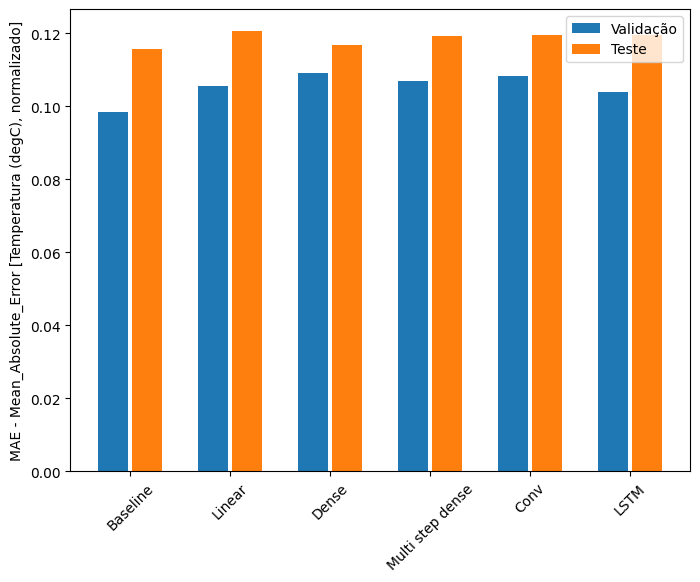

In [491]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.ylabel('MAE - Mean_Absolute_Error [Temperatura (degC), normalizado]')
plt.bar(x - 0.17, val_mae, width, label='Validação')
plt.bar(x + 0.17, test_mae, width, label='Teste')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

for name, value in performance.items():
  print(f'{name:12s}: {value[metric_name]:0.4f}')

Avaliação do gráfico:
Baseline	MAEval=~0.10	MAEtest=~0.117	Muito forte! O modelo que apenas repete a última temperatura já é bom.

Linear	~0.105	~0.121	Levemente melhor que o Baseline no Val, igual ou um pouco pior no Teste.

Dense	~0.11	~0.118	Não superou o Linear, possivelmente subajuste ou ruído.

Multi-step Dense	~0.108	~0.120	Similar ao Dense.

Conv	~0.11	~0.120	Também não ganhou vantagem, talvez porque a estrutura temporal é simples.

LSTM	~0.105	~0.122	Leve overfitting, mas desempenho similar ao Linear.


Baseline já é muito forte, então superar ele é difícil — especialmente se a temperatura varia pouco de um passo para o outro (ex: hora a hora ou 3h em 3h).

Modelos mais complexos não trouxeram ganho claro — isso pode indicar que:

As janelas são curtas (pouca informação sequencial);
Os dados são limpos e suaves;
O target tem pouca variabilidade.
Seu Linear model está praticamente no mesmo nível dos outros, o que é um ótimo sinal de que seu pipeline de predição está funcionando bem — e que a tarefa em si pode não precisar de redes profundas.

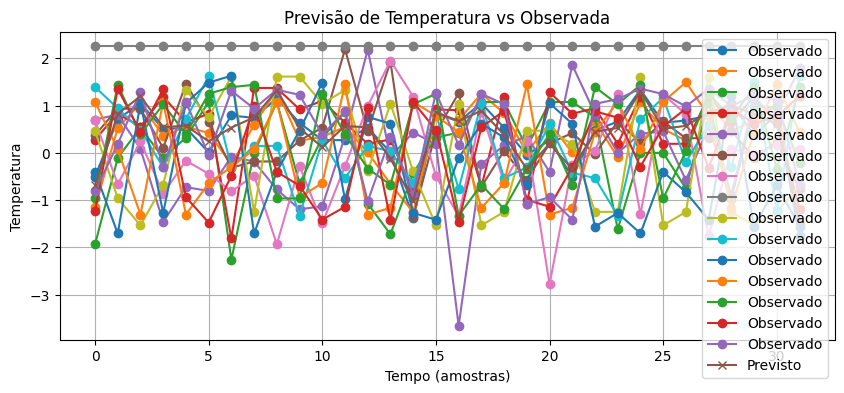

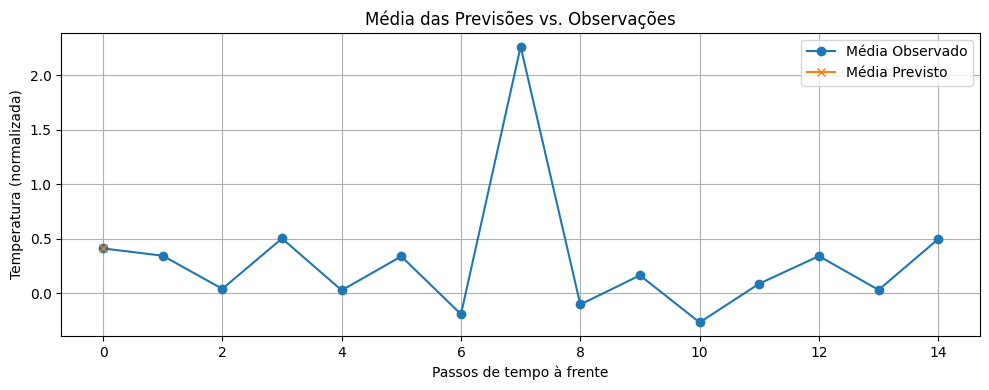

In [512]:
# Obtemos entradas e rótulos do dataset de teste
for inputs, labels in single_step_window.test.take(1):
    predictions = linear(inputs)  # modelo prevê com base nos inputs

# Escolhe o primeiro exemplo do batch

import numpy as np

# Reverter normalização

# Converter para arrays 1D para plot
true = labels.numpy().squeeze()
pred = predictions.numpy().squeeze()

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(true, label='Observado', marker='o')
plt.plot(pred, label='Previsto', marker='x')
plt.legend()
plt.title('Previsão de Temperatura vs Observada')
plt.xlabel('Tempo (amostras)')
plt.ylabel('Temperatura')
plt.grid(True)
plt.show()


import numpy as np

# Calcular a média das observações e previsões por passo de tempo
mean_true = np.mean(labels.numpy().squeeze(), axis=0)
mean_pred = np.mean(predictions.numpy().squeeze(), axis=0)

plt.figure(figsize=(10, 4))
plt.plot(mean_true, label='Média Observado', marker='o')
plt.plot(mean_pred, label='Média Previsto', marker='x')
plt.title('Média das Previsões vs. Observações')
plt.xlabel('Passos de tempo à frente')
plt.ylabel('Temperatura (normalizada)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


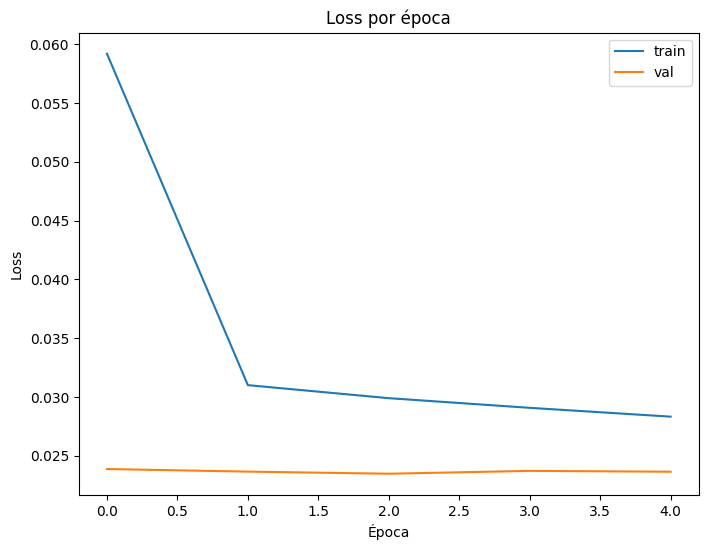

In [492]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.title('Loss por época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.show()


Multi-output models
The models so far all predicted a single output feature, T (degC), for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the labels (example_labels):

In [493]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 15)
Labels shape (batch, time, features): (32, 24, 15)
